In [1]:
%load_ext autoreload

In [3]:
%autoreload 
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from pvlib import solarposition
# from dataprep.eda import create_report

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [4]:
from featurewiz import FeatureWiz

Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



# Import the processed data

In [23]:
data_path = '../data_preprocessed/'
save_path = '../data_feature_enigineering/'

In [24]:
df = pd.read_csv(f'{data_path}df_A.csv')
df = df.set_index('date_forecast')
df.index = pd.to_datetime(df.index)

In [25]:
X_test = pd.read_csv(f'{data_path}X_test_A.csv')
X_test = X_test.set_index('date_forecast')
X_test.index = pd.to_datetime(X_test.index)
X_test.date_calc = pd.to_datetime(X_test.date_calc)


In [26]:
# move 'elevation:m', 'building', 'pv_measurement' to the end of the dataframe
df = df[[c for c in df if c not in ['elevation:m', 'building', 'pv_measurement']] 
       + ['elevation:m', 'building', 'pv_measurement']]

X_test = X_test[[c for c in X_test if c not in ['elevation:m', 'building']]
                     + ['elevation:m', 'building']]

### Add datetime features

In [27]:
# add datetime64 features to the dataframes such as hour, day, month, year, minute (not in utilities)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_year'] = df.index.dayofyear
df['day'] = df.index.day
df['minute'] = df.index.minute

X_test['hour'] = X_test.index.hour
X_test['day_of_week'] = X_test.index.day_of_week
X_test['quarter'] = X_test.index.quarter
X_test['month'] = X_test.index.month
X_test['year'] = X_test.index.year
X_test['day_of_year'] = X_test.index.dayofyear
X_test['day'] = X_test.index.day
X_test['minute'] = X_test.index.minute

#### Adding some new features:

Trying some intuitive features

In [28]:
# Derived Features
df['temp_dewpoint_diff'] = df['dew_point_2m:K'] - df['t_1000hPa:K']
df['solar_radiation_ratio'] = df['direct_rad:W'] / df['clear_sky_rad:W']

# Weather-related Features
df['wind_speed_magnitude'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2 + df['wind_speed_w_1000hPa:ms']**2)**0.5
df['cumulative_precipitation'] = df['precip_5min:mm'].rolling(window=12).sum()  # Sum over the past 1 hour (5*12 = 60 minutes)

# Interaction Features
df['temp_solar_interaction'] = df['t_1000hPa:K'] * df['direct_rad:W']

In [29]:
# Derived Features
X_test['temp_dewpoint_diff'] = X_test['dew_point_2m:K'] - X_test['t_1000hPa:K']
X_test['solar_radiation_ratio'] = X_test['direct_rad:W'] / X_test['clear_sky_rad:W']

# Weather-related Features
X_test['wind_speed_magnitude'] = (X_test['wind_speed_u_10m:ms']**2 + X_test['wind_speed_v_10m:ms']**2 + X_test['wind_speed_w_1000hPa:ms']**2)**0.5
X_test['cumulative_precipitation'] = X_test['precip_5min:mm'].rolling(window=12).sum()  # Sum over the past 1 hour (5*12 = 60 minutes)

# Interaction Features
X_test['temp_solar_interaction'] = X_test['t_1000hPa:K'] * X_test['direct_rad:W']

Trying some pv related features generated using a solar power library. NB assuming the buildings are located in Trondheim

In [30]:
# Function to add solar-related features using pvlib
def add_solar_features_pvlib(df):
    # Fixed latitude and longitude
    latitude = 63.430515
    longitude = 10.395053

    times = pd.to_datetime(df[['year','month', 'day', 'hour', 'minute']])
    altitudes = df['elevation:m']
    temperatures = df['t_1000hPa:K'] - 273.15
    
    # Calculate solar positions
    solar_position = solarposition.get_solarposition(times, latitude, longitude, altitudes, temperature=temperatures)

    # Add solar position features to the dataframe
    df['sun_zenith:d'] = solar_position['apparent_zenith']
    df['sun_equation_of_time'] = solar_position['equation_of_time']

    return df

In [31]:
df = add_solar_features_pvlib(df)
X_test = add_solar_features_pvlib(X_test)

In [32]:
df.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,day_of_year,day,minute,temp_dewpoint_diff,solar_radiation_ratio,wind_speed_magnitude,cumulative_precipitation,temp_solar_interaction,sun_zenith:d,sun_equation_of_time
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,7.7,1.230,1744.9,0.0,0.0,1744.9,0.0,280.3,0.0,0.0,...,153,2,0,-5.6,NaN,3.687818,NaN,0.0,93.025084,1.968588
2019-06-02 22:15:00,7.7,1.229,1734.0,0.0,0.0,1734.0,0.0,280.3,0.0,0.0,...,153,2,15,-5.8,NaN,3.649658,NaN,0.0,93.484495,1.966891
2019-06-02 22:30:00,7.7,1.228,1723.5,0.0,0.0,1723.5,0.0,280.3,0.0,0.0,...,153,2,30,-6.0,NaN,3.622154,NaN,0.0,93.845971,1.965194
2019-06-02 22:45:00,7.7,1.226,1713.4,0.0,0.0,1713.4,0.0,280.3,0.0,0.0,...,153,2,45,-6.3,NaN,3.505710,NaN,0.0,94.107859,1.963496
2019-06-02 23:00:00,7.7,1.225,1703.6,0.0,0.0,1703.6,0.0,280.3,0.0,0.0,...,153,2,0,-6.5,NaN,3.500000,NaN,0.0,94.268944,1.961797


In [33]:
X_test.head()

,date_calc,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,day_of_year,day,minute,temp_dewpoint_diff,solar_radiation_ratio,wind_speed_magnitude,cumulative_precipitation,temp_solar_interaction,sun_zenith:d,sun_equation_of_time
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,2023-04-30 07:00:04,4.4,1.286,912.7,0.0,0.0,1041.2,0.0,271.7,0.0,...,121,1,0,-2.1,NaN,4.049691,NaN,0.0,101.166019,2.806174
2023-05-01 00:15:00,2023-04-30 07:00:04,4.3,1.287,912.7,0.0,0.0,1054.8,0.0,271.7,0.0,...,121,1,15,-2.1,NaN,3.996248,NaN,0.0,100.792356,2.807480
2023-05-01 00:30:00,2023-04-30 07:00:04,4.3,1.287,912.7,0.0,0.0,1068.3,0.0,271.6,0.0,...,121,1,30,-2.2,NaN,3.911521,NaN,0.0,100.314960,2.808785
2023-05-01 00:45:00,2023-04-30 07:00:04,4.3,1.287,912.7,0.0,0.0,1081.9,0.0,271.6,0.0,...,121,1,45,-2.2,NaN,3.858756,NaN,0.0,99.736307,2.810090
2023-05-01 01:00:00,2023-04-30 07:00:04,4.3,1.287,NaN,0.0,0.0,1095.4,0.0,271.6,0.0,...,121,1,0,-2.2,NaN,3.858756,NaN,0.0,99.059338,2.811393


In [34]:
# check for missing values
df.isnull().sum()

absolute_humidity_2m:gm3               0
air_density_2m:kgm3                    0
ceiling_height_agl:m               26166
clear_sky_energy_1h:J                  0
clear_sky_rad:W                        0
cloud_base_agl:m                   10160
dew_or_rime:idx                        0
dew_point_2m:K                         0
diffuse_rad:W                          0
diffuse_rad_1h:J                       0
direct_rad:W                           0
direct_rad_1h:J                        0
effective_cloud_cover:p                0
fresh_snow_12h:cm                      0
fresh_snow_1h:cm                       0
fresh_snow_24h:cm                      0
fresh_snow_3h:cm                       0
fresh_snow_6h:cm                       0
is_day:idx                             0
is_in_shadow:idx                       0
msl_pressure:hPa                       0
precip_5min:mm                         0
precip_type_5min:idx                   0
pressure_100m:hPa                      0
pressure_50m:hPa

In [35]:
X_test.isnull().sum()

date_calc                           0
absolute_humidity_2m:gm3            0
air_density_2m:kgm3                 0
ceiling_height_agl:m              793
clear_sky_energy_1h:J               0
clear_sky_rad:W                     0
cloud_base_agl:m                  298
dew_or_rime:idx                     0
dew_point_2m:K                      0
diffuse_rad:W                       0
diffuse_rad_1h:J                    0
direct_rad:W                        0
direct_rad_1h:J                     0
effective_cloud_cover:p             0
fresh_snow_12h:cm                   0
fresh_snow_1h:cm                    0
fresh_snow_24h:cm                   0
fresh_snow_3h:cm                    0
fresh_snow_6h:cm                    0
is_day:idx                          0
is_in_shadow:idx                    0
msl_pressure:hPa                    0
precip_5min:mm                      0
precip_type_5min:idx                0
pressure_100m:hPa                   0
pressure_50m:hPa                    0
prob_rime:p 

#### We have weather features for each quarter but only pv_measurment for each hour, we want to create a new dataframe where we use the average feature data for each pv_measurement

In [36]:
# cerate a new temporary dataframe by removing pv_measurement from df
df_temp = df.drop(columns=['pv_measurement', 'building', 'elevation:m'])

# for each whole hour, replace the features with the mean of the past 60 minutes
df_temp = df_temp.resample('H').mean().ffill().bfill()

In [37]:
# add 'pv_measurement', 'building', 'elevation:m' back to df_temp at the same indexes
df_temp['pv_measurement'] = df['pv_measurement']
# df_temp['building'] = df['building']
# df_temp['elevation:m'] = df['elevation:m']
df = df_temp

No handles with labels found to put in legend.


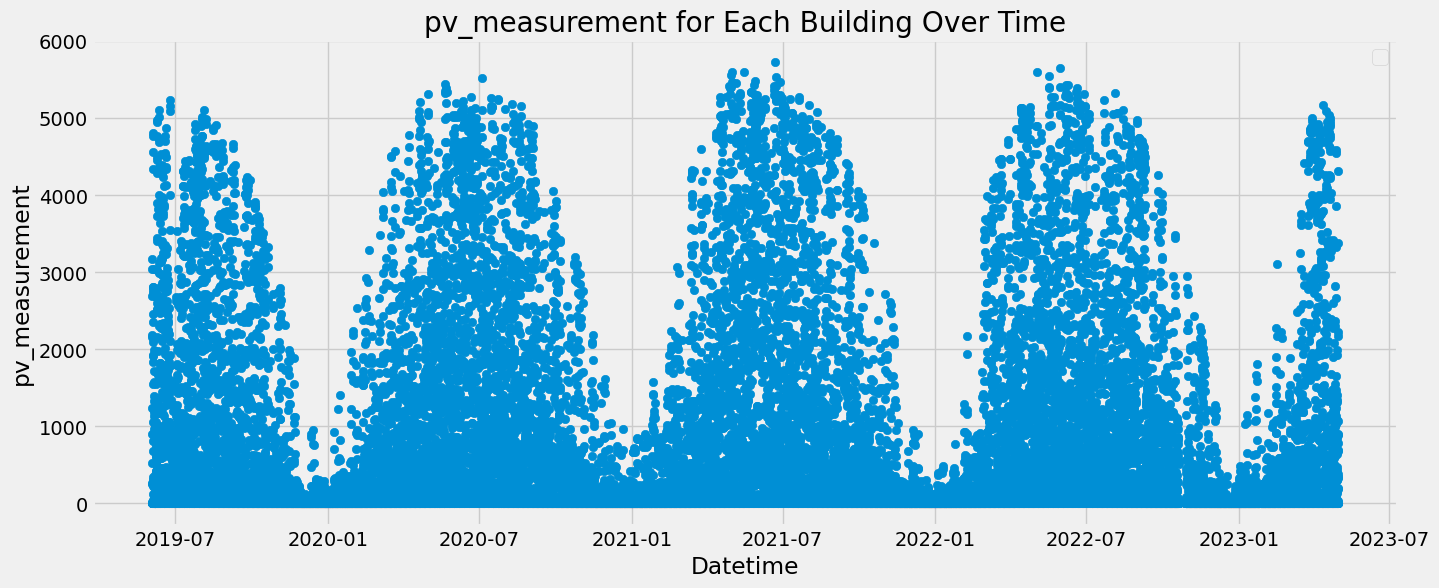

In [38]:
plt.figure(figsize=(15, 6))

plt.scatter(df.index, df['pv_measurement'], marker='o')

plt.xlabel('Datetime')
plt.ylabel('pv_measurement')
plt.title('pv_measurement for Each Building Over Time')
plt.legend()
plt.show()

### Seems like it worked :o

In [39]:
df_temp.isnull().sum()

absolute_humidity_2m:gm3            0
air_density_2m:kgm3                 0
ceiling_height_agl:m                0
clear_sky_energy_1h:J               0
clear_sky_rad:W                     0
cloud_base_agl:m                    0
dew_or_rime:idx                     0
dew_point_2m:K                      0
diffuse_rad:W                       0
diffuse_rad_1h:J                    0
direct_rad:W                        0
direct_rad_1h:J                     0
effective_cloud_cover:p             0
fresh_snow_12h:cm                   0
fresh_snow_1h:cm                    0
fresh_snow_24h:cm                   0
fresh_snow_3h:cm                    0
fresh_snow_6h:cm                    0
is_day:idx                          0
is_in_shadow:idx                    0
msl_pressure:hPa                    0
precip_5min:mm                      0
precip_type_5min:idx                0
pressure_100m:hPa                   0
pressure_50m:hPa                    0
prob_rime:p                         0
rain_water:k

In [40]:
# remove all rows where pv_measurement is NaN
df = df.dropna(subset=['pv_measurement'])
df.isnull().sum()

absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                       0
rain_water:kgm2                   0
relative_humidity_1000hPa:p 

#### Automativ featued analysis and selection using FeatureWiz

In [41]:
FEATURES = list(df.columns)

FEATURES.remove('pv_measurement')

TARGET = 'pv_measurement'

X_train = df[FEATURES]
y_train = df[TARGET]

X_test = X_test[FEATURES]

In [42]:
FEATURES

['absolute_humidity_2m:gm3',
 'air_density_2m:kgm3',
 'ceiling_height_agl:m',
 'clear_sky_energy_1h:J',
 'clear_sky_rad:W',
 'cloud_base_agl:m',
 'dew_or_rime:idx',
 'dew_point_2m:K',
 'diffuse_rad:W',
 'diffuse_rad_1h:J',
 'direct_rad:W',
 'direct_rad_1h:J',
 'effective_cloud_cover:p',
 'fresh_snow_12h:cm',
 'fresh_snow_1h:cm',
 'fresh_snow_24h:cm',
 'fresh_snow_3h:cm',
 'fresh_snow_6h:cm',
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm',
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa',
 'prob_rime:p',
 'rain_water:kgm2',
 'relative_humidity_1000hPa:p',
 'sfc_pressure:hPa',
 'snow_water:kgm2',
 'sun_azimuth:d',
 'sun_elevation:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K',
 'total_cloud_cover:p',
 'visibility:m',
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_speed_v_10m:ms',
 'wind_speed_w_1000hPa:ms',
 'hour',
 'day_of_week',
 'quarter',
 'month',
 'year',
 'day_of_year',
 'day',
 'minute',
 'temp_dewpoint_diff',
 'solar_ra

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (34061, 56)
    Some column names had special characters which were removed...
#### Single_Label Re

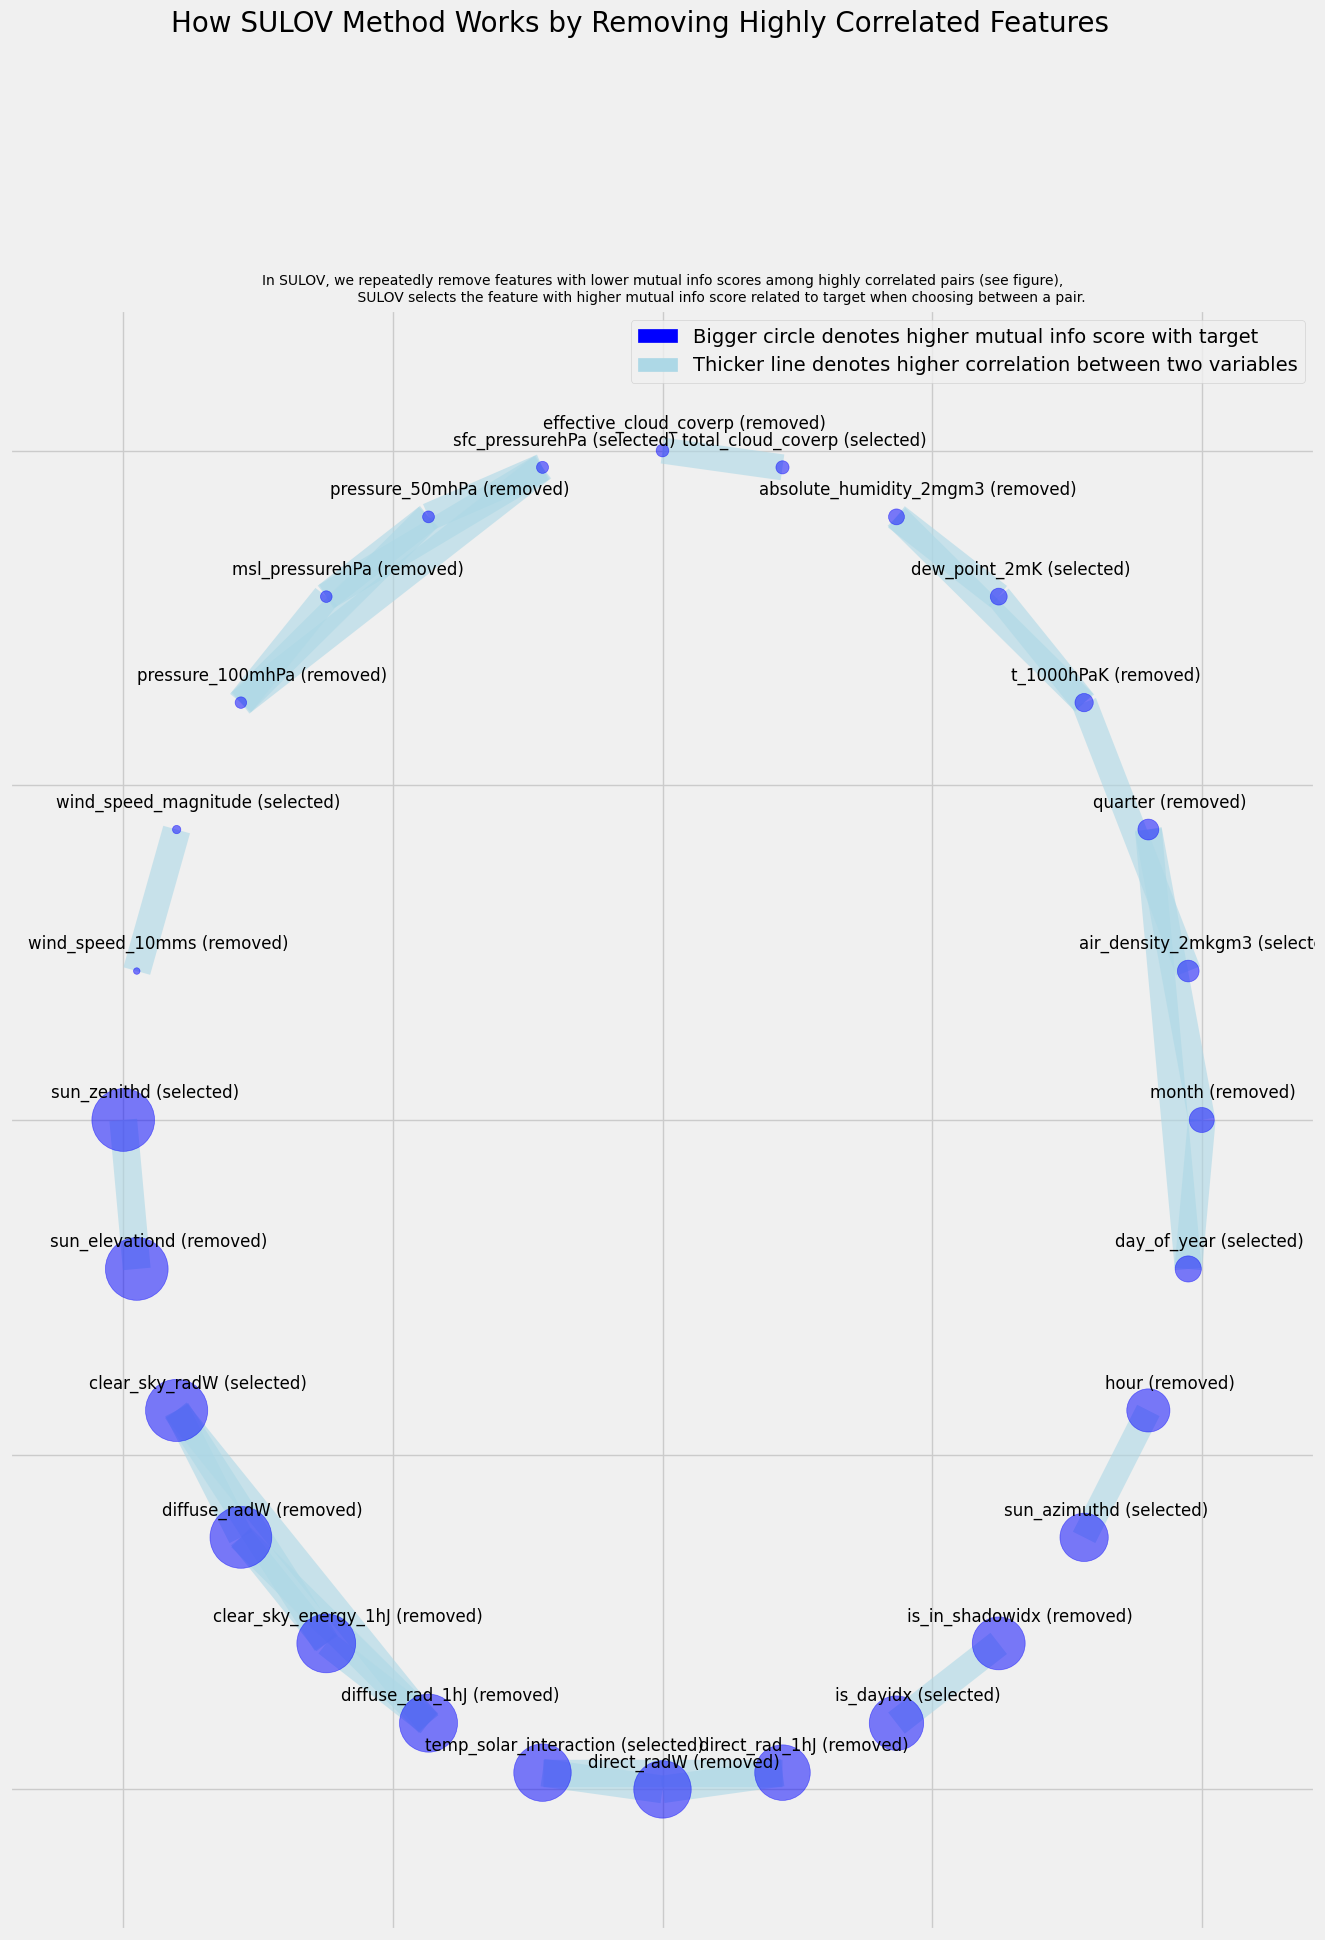

Time taken for SULOV method = 5 seconds
    Adding 0 categorical variables to reduced numeric variables  of 37
Finally 37 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 10 features per iteration...
    XGBoost version using 1.6.2 as tree method: hist
    Number of booster rounds = 100
        Selected: ['temp_solar_interaction', 'clear_sky_radW', 'sun_zenithd', 'sun_azimuthd', 'sun_equation_of_time', 'wind_speed_u_10mms', 'sfc_pressurehPa', 'solar_radiation_ratio', 'dew_point_2mK', 'ceiling_height_aglm']
            Time taken for regular XGBoost feature selection = 2 seconds
        Selected: ['temp_solar_interaction', 'clear_sky_radW', 'sun_z

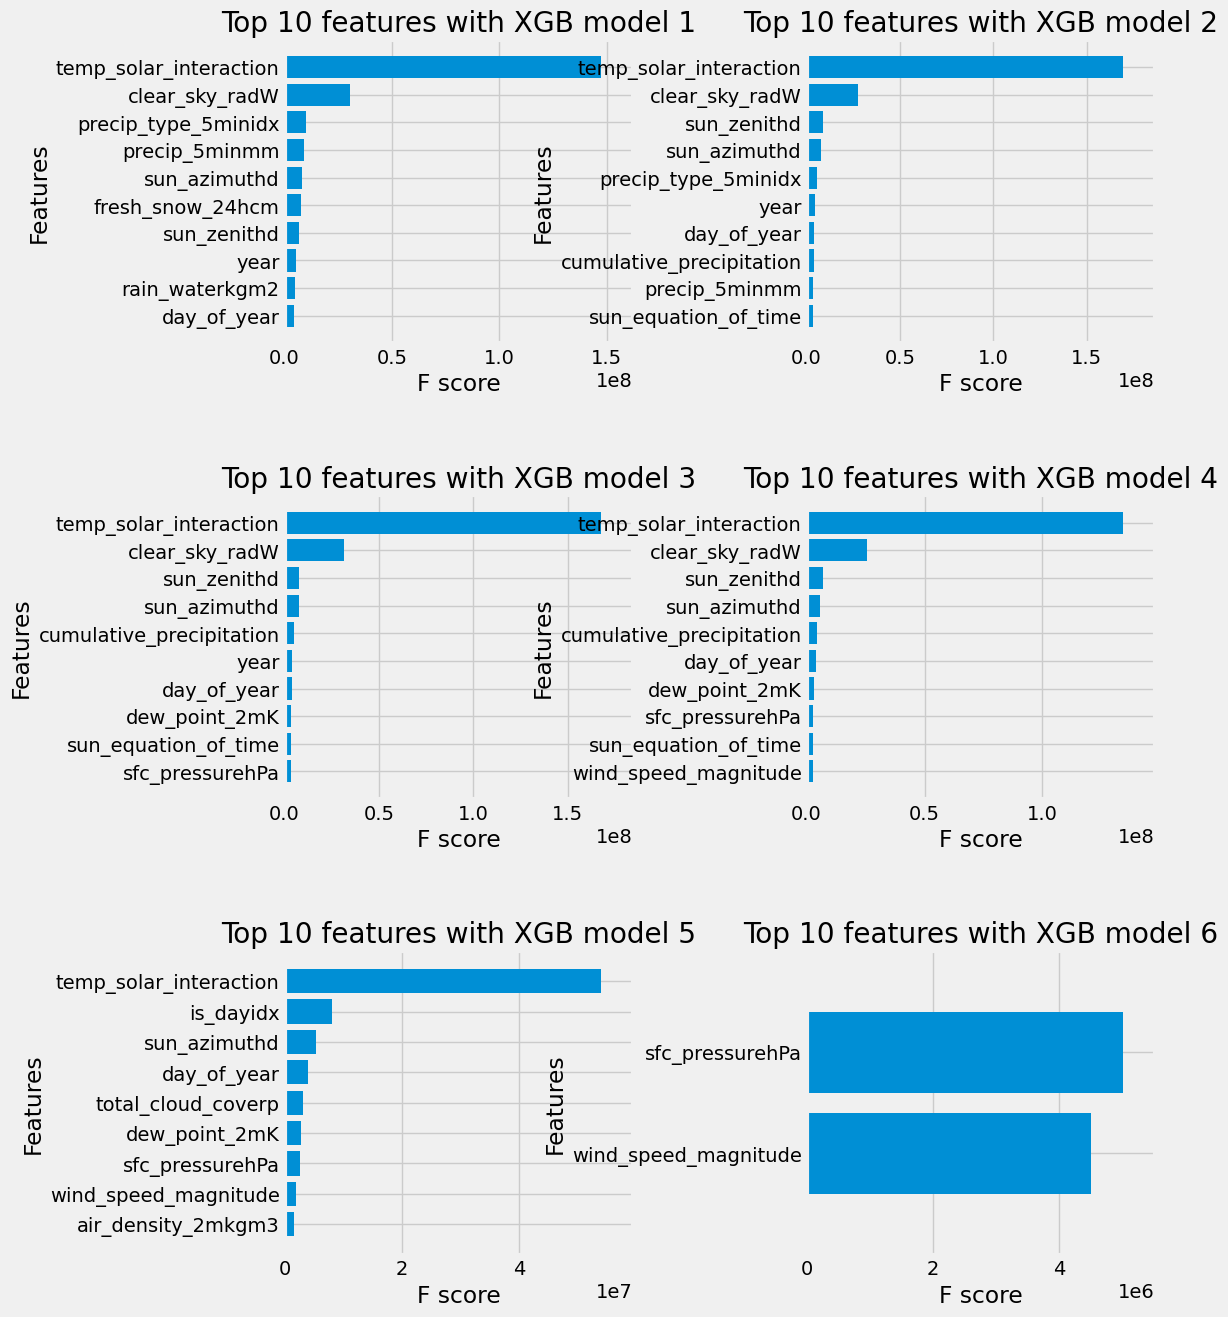

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 18 important features:
['temp_solar_interaction', 'clear_sky_radW', 'sun_zenithd', 'sun_azimuthd', 'sun_equation_of_time', 'wind_speed_u_10mms', 'sfc_pressurehPa', 'solar_radiation_ratio', 'dew_point_2mK', 'ceiling_height_aglm', 'day', 'visibilitym', 'wind_speed_magnitude', 'temp_dewpoint_diff', 'day_of_year', 'total_cloud_coverp', 'air_density_2mkgm3', 'is_dayidx']
Total Time taken for featurewiz selection = 15 seconds
Output contains a list of 18 important features and a train dataframe
    Time taken to create entire pipeline = 15 second(s)


In [43]:
fwiz = FeatureWiz(corr_limit=0.9, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = fwiz.fit_transform(X_train, y_train)
X_test_selected = fwiz.transform(X_test)
### get list of selected features ###
feats = fwiz.features  

In [44]:
X_train_selected.shape

(34061, 18)

In [45]:
X_test_selected.shape

(2880, 18)

In [46]:
# save X_train_selected and X_test_selected
X_train_selected.to_csv(f'{save_path}X_train_selected_A.csv')
X_test_selected.to_csv(f'{save_path}X_test_selected_A.csv')

In [47]:
# save y_train
y_train.to_csv(f'{save_path}y_train_A.csv')